# Uncertainties in DNNs

Load dependencies:

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import warnings
from tensorflow_probability import layers, distributions

In [2]:
# create artificial regression dataset
def get_data(N=500, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, np.newaxis], np.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, np.newaxis], np.arange(D_X))

    return X, Y, X_test

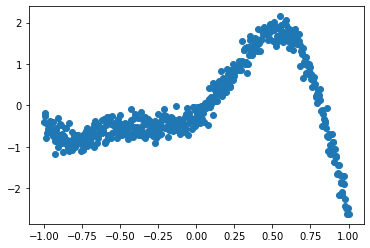

In [3]:
X, Y, X_test = get_data(D_X=2)
plt.scatter(X[:,1], Y)


## Linear regression model

In [8]:
def linear_model(X, Y,  epochs=100, batch_size=25):

    # no hidden layers!
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=1, activation=None)
    ])
    model.summary()
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, 1.0 ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, _, model.predict(X)

# in R lm(Y~X)
def linear_model_std(X, Y,  epochs=100, batch_size=25):

    # no hidden layers!
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=1, activation=None)
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1], 0,10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1],0,10), model.predict(X)

def DNN_model(X, Y,  epochs=100, batch_size=25, hidden = 10):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=1, activation=None)
    ])
    model.summary()
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, 1.0 ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, _, model.predict(X)

def DNN_model_std(X, Y,  epochs=100, batch_size=25, hidden=10):

    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=hidden, activation="relu"),
        tf.keras.layers.Dense(units=1)
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1],0, 10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1],0,10), model.predict(X)

In [9]:
with tf.device("CPU"):
    results = linear_model(X, Y)
    results_std = linear_model_std(X, Y)
    results_dnn = DNN_model(X, Y)
    results_dnn_std = DNN_model_std(X, Y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


2022-02-11 08:47:12.333377: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 151
Trainable params: 15

LM without std:

In [11]:
print(f'Estimated weights: {*[w.squeeze().tolist() for w in results[0].get_weights()], }' )

Estimated weights: ([0.10738595575094223, 0.748291552066803], -0.10916591435670853)


LM with std:

In [12]:
print(f'Estimated weights: {*[w.squeeze().tolist() for w in results_std[0].get_weights()], }' )
print(f'LM: True std: 0.05', f'Estimated std: {results_std[2]}')
print(f'DNN: True std: 0.05', f'Estimated std: {results_dnn_std[2]}')

Estimated weights: ([0.1701505333185196, 0.7497166991233826], -0.1663428694009781, 0.9050726890563965)
LM: True std: 0.3 Estimated std: 0.9050726890563965
DNN: True std: 0.3 Estimated std: 0.2036627233028412


<Figure size 432x288 with 0 Axes>

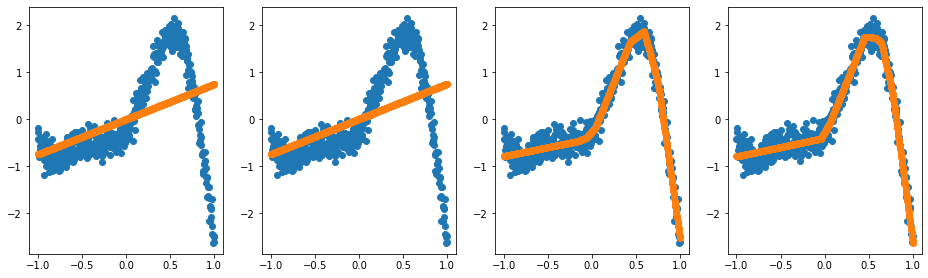

In [13]:
fig = plt.figure()
plt.figure(figsize=(16, 10))
plt.subplot(2, 4, 1)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results[3])
plt.subplot(2, 4, 2)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results_std[3])
plt.subplot(2, 4, 3)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results_dnn[3])
plt.subplot(2, 4, 4)
plt.scatter(X[:,1], Y)
plt.scatter(X[:,1], results_dnn_std[3])


But no CIs!

## Bayesian Neural Networks

Help functions:

In [40]:
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=5*tf.ones(n)
                )
            )
        ]
    )
    return prior_model
 
# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n*2, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
          tfp.distributions.Normal(loc=t[0:n], scale=tf.exp(t[n:])),
          reinterpreted_batch_ndims=1)),
  ])
 
# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior_MVN(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

def posterior_diag(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.IndependentNormal.params_size(n), dtype=dtype
            ),
            tfp.layers.IndependentNormal(n),
        ]
    )
    return posterior_model

In [4]:
def BNN_model_linear(X, Y, epochs=100, batch_size=100, posterior="diag"):
    if posterior == "MVN":
        posterior = posterior_MVN
    else:
        posterior = posterior_diag
    
    train_size = X.shape[0]
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tfp.layers.DenseVariational(
            units=1,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=None,
            kl_use_exact=True),
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    
    # loss function: Normal log-ll with constant std
    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1], 0, 10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.01))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 0)
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1], 0, 10), tf.concat([model(X) for _ in range(100)], axis = 1).numpy()

def BNN_model(X, Y, epochs=100, batch_size=100, hidden=10, posterior="diag"):
    if posterior == "MVN":
        posterior = posterior_MVN
    else:
        posterior = posterior_diag
    train_size = X.shape[0]
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tfp.layers.DenseVariational(
            units=hidden,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="tanh",
            kl_use_exact=True),
        tfp.layers.DenseVariational(
            units=1,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation=None,
            kl_use_exact=True),
        #tf.keras.layers.Dense(1, activation=None),
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    

    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1], 0, 10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0001))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 1)
    pred = tf.concat([model(X) for _ in range(100)], axis = 1).numpy()
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1], 0 , 10), pred

def BNN_model_flipout(X, Y, epochs=100, batch_size=100, hidden=10):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=[X.shape[1]]),
        tfp.layers.DenseReparameterization(
            units=hidden,
            activation="tanh"),
        tfp.layers.DenseReparameterization(
            units=1,
            activation=None),
        #tf.keras.layers.Dense(1, activation=None),
    ])
    model.summary()
    model.add_weight(name = "stddev", 
                    shape=(), 
                    initializer = tf.keras.initializers.Constant(value=1.0),
                    trainable=True)
    

    ll = lambda true, obs: -tfp.distributions.Normal(obs, tf.clip_by_value(model.trainable_variables[-1], 0, 10) ).log_prob(true)
    model.compile(loss = ll, optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001))
    model.fit(X, Y, epochs = epochs, batch_size = batch_size, verbose = 1)
    return model, model.trainable_variables, tf.clip_by_value(model.trainable_variables[-1], 0 , 10)

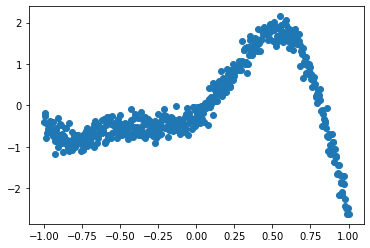

In [5]:
X, Y, X_test = get_data(D_X=2)
plt.scatter(X[:,1], Y)

In [6]:
with tf.device("CPU"):
    #results = BNN_model_linear(X, Y, posterior="MVN")
    #results_dnn = BNN_model(X, Y, epochs=1000, hidden=10, batch_size=200,posterior="MVN")
    results_dnn_flipout = BNN_model_flipout(X, Y, epochs=1000, hidden=20, batch_size=100)


2022-02-11 09:31:57.545024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-11 09:31:57.546066: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/maximilianpichler/tensorflow-test/env/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/Users/maximilianpichler/tensorflow-test/env/lib/python3.8/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future ve

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_reparameterization (D  (None, 20)               100       
 enseReparameterization)                                         
                                                                 
 dense_reparameterization_1   (None, 1)                41        
 (DenseReparameterization)                                       
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


2022-02-11 09:31:57.792214: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000
5/5 [==============================] - 0s 753us/step - loss: 153.3445
Epoch 2/1000
5/5 [==============================] - 0s 2ms/step - loss: 153.0288
Epoch 3/1000
5/5 [==============================] - 0s 2ms/step - loss: 152.7159
Epoch 4/1000
5/5 [==============================] - 0s 2ms/step - loss: 152.4064
Epoch 5/1000
5/5 [==============================] - 0s 1ms/step - loss: 152.1047
Epoch 6/1000
5/5 [==============================] - 0s 2ms/step - loss: 151.7982
Epoch 7/1000
5/5 [==============================] - 0s 2ms/step - loss: 151.4884
Epoch 8/1000
5/5 [==============================] - 0s 2ms/step - loss: 151.1825
Epoch 9/1000
5/5 [==============================] - 0s 2ms/step - loss: 150.8804
Epoch 10/1000
5/5 [==============================] - 0s 2ms/step - loss: 150.5757
Epoch 11/1000
5/5 [==============================] - 0s 3ms/step - loss: 150.2806
Epoch 12/1000
5/5 [==============================] - 0s 2ms/step - loss: 149.9720
Epoch 13/1000
5/5 [====

In [65]:
print(f'Linear: True std: 0.05', f'Estimated std: {results[2]}')
print(f'DNN: True std: 0.05', f'Estimated std: {results_dnn[2]}')
print(f'DNN: True std: 0.05', f'Estimated std: {results_dnn_flipout[2]}')

Linear: True std: 0.05 Estimated std: 1.1265968084335327
DNN: True std: 0.05 Estimated std: 1.034591794013977
DNN: True std: 0.05 Estimated std: 2.526911497116089


Plot results:

2022-02-11 09:15:32.937009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


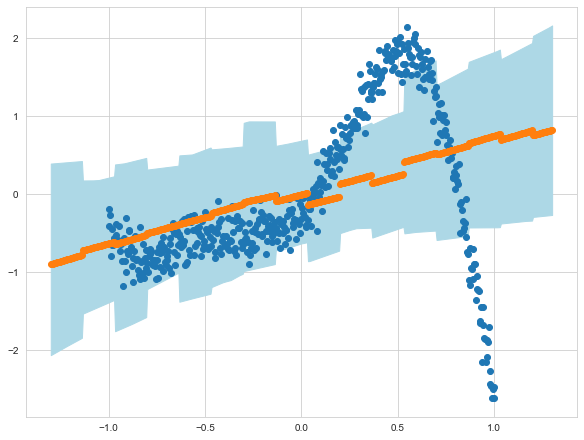

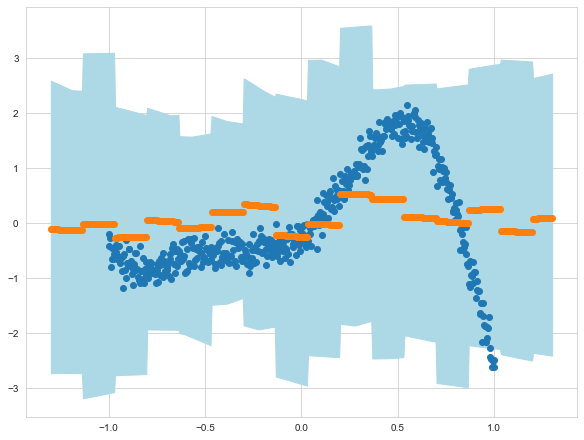

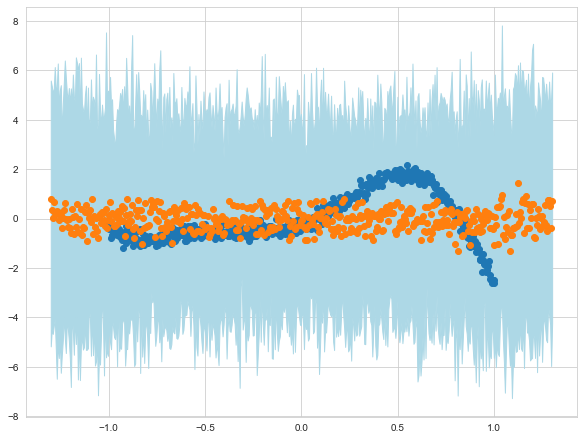

In [66]:
XT = tf.constant(X_test, dtype="float32")


predictive = tf.transpose(tf.concat([results[0].predict(XT) for _ in range(50)], 1)).numpy()
means = np.mean(predictive ,0)
percs = np.percentile(predictive, [5., 95.], axis=0).squeeze()
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.fill_between(X_test[:,1], percs[0,:], percs[1,:], color="lightblue")
ax.scatter(X[:,1], Y)
ax.scatter(X_test[:,1], means)

predictive = tf.transpose(tf.concat([results_dnn[0].predict(XT) for _ in range(50)], 1)).numpy()
means = np.mean(predictive ,0)
percs = np.percentile(predictive, [5., 95.], axis=0).squeeze()
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.fill_between(X_test[:,1], percs[0,:], percs[1,:], color="lightblue")
ax.scatter(X[:,1], Y)
ax.scatter(X_test[:,1], means)

predictive = tf.transpose(tf.concat([results_dnn_flipout[0].predict(XT) for _ in range(50)], 1)).numpy()
means = np.mean(predictive ,0)
percs = np.percentile(predictive, [5., 95.], axis=0).squeeze()
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.fill_between(X_test[:,1], percs[0,:], percs[1,:], color="lightblue")
ax.scatter(X[:,1], Y)
ax.scatter(X_test[:,1], means)

Let's take a look at the posterior distribution of our weights for the linear BNN:

In [37]:
posterior = results[0].layers[0]._posterior(np.array([[0]]))
prior = results[0].layers[0]._prior(np.array([[0]]))

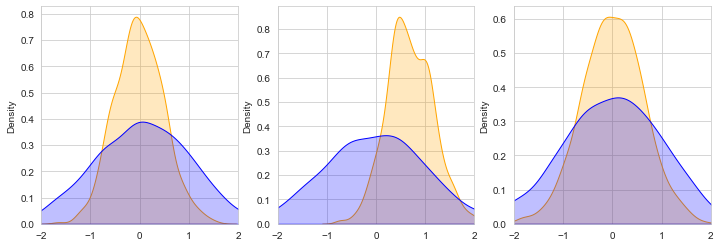

In [38]:
warnings.filterwarnings('ignore')
samples = posterior.sample(1000).numpy()
prior_samples = prior.sample(1000).numpy()
sn.set_style('whitegrid')
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.xlim(-2, 2)
    sn.distplot(samples[:,i], color="orange", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})
    sn.distplot(prior_samples[:,i], color="blue", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})

#sn.displot(pd.DataFrame({"x": samples[:,0], "y": samples[:,1]}),x="x",y="y", kind="kde")


BNN weights:

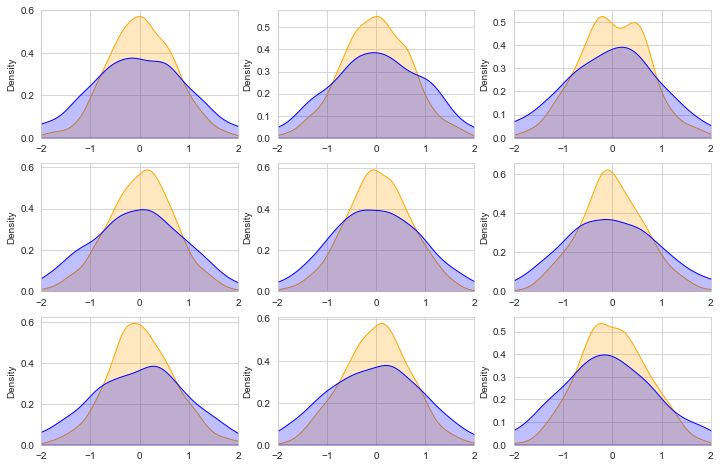

In [39]:
posterior = results_dnn[0].layers[0]._posterior(np.array([[0]]))
prior = results_dnn[0].layers[0]._prior(np.array([[0]]))
samples = posterior.sample(1000).numpy()
prior_samples = prior.sample(1000).numpy()
sn.set_style('whitegrid')
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.xlim(-2, 2)
    sn.distplot(samples[:,i], color="orange", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})
    sn.distplot(prior_samples[:,i], color="blue", hist=False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1})